In [1]:
import zipfile
import os
import json
import pandas as pd
from datetime import datetime, timedelta

In [2]:
zip_path = r"C:\Users\andreyb\Downloads\jsons.zip"
parquet_path = r"C:\Users\andreyb\Downloads\deal_delqs_logs.pq"
extract_dir = r"C:\Users\andreyb\Downloads\jsons_extracted"

# Распаковка zip архива

In [4]:
# Распаковка zip архива
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [50]:
jsons_folder = r'C:\Users\andreyb\Downloads\jsons_extracted\jsons'

data = []

for filename in os.listdir(jsons_folder):
    if filename.endswith('.json'):
        filepath = os.path.join(jsons_folder, filename)
        with open(filepath, 'r', encoding='utf-8') as f:
            js = json.load(f)

        loan_id = js.get('loanID')
        event_time = js.get('eventTime')
        model_id = js.get('modelID')

        # Предполагаем, что нужен скоринг "pd" из values
        score = None
        if 'values' in js and 'pd' in js['values']:
            score = js['values']['pd']

        data.append({
            'loan_id': loan_id,
            'event_time': pd.to_datetime(event_time),
            'model_id': model_id,
            'score': score,
        })

In [51]:
df_scores = pd.DataFrame(data)
print(df_scores.head())

                loan_id              event_time            model_id     score
0        CC2024043011d0 2024-04-30 07:16:48.741        pd-cc-online  0.134959
1       CAR20240213645e 2024-02-13 11:27:10.937      pd-auto-online       NaN
2  MORTGAGE20240116754e 2024-01-16 07:52:06.260  pd-mortgage-online  0.075389
3        CC202403029ee2 2024-03-02 23:00:46.748        pd-cc-online  0.150639
4       CAR2024010306b1 2024-01-03 16:05:31.680      pd-auto-online       NaN


# Загрузка JSON

In [52]:
data = []
for filename in os.listdir(jsons_folder):
    if filename.endswith('.json'):
        with open(os.path.join(jsons_folder, filename), 'r', encoding='utf-8') as f:
            js = json.load(f)

        loan_id = js.get('loanID')
        event_time = js.get('eventTime')
        model_id = js.get('modelID')
        score = None
        if 'values' in js and 'pd' in js['values']:
            score = js['values']['pd']

        data.append({
            'loan_id': loan_id,
            'event_time': pd.to_datetime(event_time),
            'model_id': model_id,
            'score': score
        })

df_scores = pd.DataFrame(data)

# Загрузка parquet

In [53]:
df_overdue = pd.read_parquet(parquet_path)

# Приведение колонок к datetime
df_overdue['period_start_date'] = pd.to_datetime(df_overdue['period_start_date'])
df_overdue['period_end_date'] = pd.to_datetime(df_overdue['period_end_date'])

# Вычисляем флаг дефолта

In [54]:
def check_default(loan_id, scoring_date, overdue_df):
    # Фильтруем просрочки по loan_id
    overdue_events = overdue_df[overdue_df['loan_id'] == loan_id]

    # Период проверки: от даты скоринга до +4 месяцев
    limit_date = scoring_date + pd.DateOffset(months=4)

    for _, row in overdue_events.iterrows():
        start = row['period_start_date']
        end = row['period_end_date']
        duration = (end - start).days
        if duration >= 30 and start >= scoring_date and start <= limit_date:
            return True
    return False

In [55]:
df_scores['default_flag'] = df_scores.apply(
    lambda row: check_default(row['loan_id'], row['event_time'], df_overdue), axis=1)

In [56]:
# Итоговый DataFrame с флагами дефолта и предсказаниями скоринга
print(df_scores.head())

                loan_id              event_time            model_id     score  \
0        CC2024043011d0 2024-04-30 07:16:48.741        pd-cc-online  0.134959   
1       CAR20240213645e 2024-02-13 11:27:10.937      pd-auto-online       NaN   
2  MORTGAGE20240116754e 2024-01-16 07:52:06.260  pd-mortgage-online  0.075389   
3        CC202403029ee2 2024-03-02 23:00:46.748        pd-cc-online  0.150639   
4       CAR2024010306b1 2024-01-03 16:05:31.680      pd-auto-online       NaN   

   default_flag  
0         False  
1         False  
2         False  
3         False  
4         False  


# Динамика Gini для каждого из скоров по месячным срезам

In [57]:
# Функция расчета коэффициента Джини
def gini(actual, pred):
    assert len(actual) == len(pred)
    all_data = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float64)
    all_data = all_data[np.lexsort((all_data[:,2], -1 * all_data[:,1]))]
    total_losses = all_data[:,0].sum()
    gini_sum = all_data[:,0].cumsum().sum() / total_losses
    gini_sum -= (len(actual) + 1) / 2.
    return gini_sum / len(actual)

In [58]:
def gini_normalized(actual, pred):
    return gini(actual, pred) / gini(actual, actual)

In [59]:
# 1. Приводим дату к периоду месяца для группировки
df_scores['scoring_month'] = pd.to_datetime(df_scores['event_time']).dt.to_period('M')

In [61]:
# 2. Группируем по месяцу и считаем Gini
gini_monthly = df_scores.groupby('scoring_month').apply(
    lambda x: gini_normalized(x['default_flag'], x['score']),
    include_groups=False
).reset_index(name='gini')

print(gini_monthly)

  scoring_month      gini
0       2024-01 -0.531011
1       2024-02 -0.547687
2       2024-03 -0.536863
3       2024-04 -0.536905
4       2024-05 -0.530061
5       2024-06 -0.546382


In [64]:
from scipy.stats import bootstrap
import numpy as np

# Помесячная динамика границ 95% доверительного интервала с использованием бутстрепа

In [65]:
confidence_intervals = []

for period, group in df_scores.groupby('scoring_month'):
    n = int(0.7 * len(group))  # 70% случайных записей
    bootstrap_ginis = []

    for _ in range(1000):
        sample = group.sample(n, replace=True)
        g = gini_normalized(sample['default_flag'].values, sample['score'].values)
        bootstrap_ginis.append(g)

    lower_bound, upper_bound = np.percentile(bootstrap_ginis, [2.5, 97.5])
    confidence_intervals.append({
        'scoring_month': period,
        'gini_lower': lower_bound,
        'gini_upper': upper_bound
    })

In [66]:
conf_df = pd.DataFrame(confidence_intervals)

print(conf_df)

  scoring_month  gini_lower  gini_upper
0       2024-01   -0.569211   -0.517204
1       2024-02   -0.570950   -0.508744
2       2024-03   -0.569183   -0.516041
3       2024-04   -0.571613   -0.515208
4       2024-05   -0.569604   -0.515463
5       2024-06   -0.578208   -0.524586


In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [69]:
# Преобразование месяца в строку
conf_df['scoring_month_str'] = conf_df['scoring_month'].astype(str)

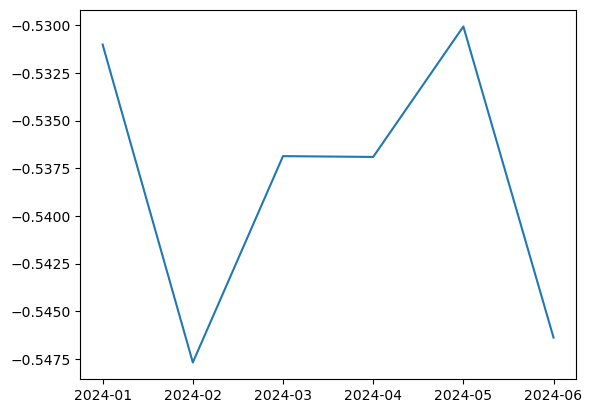

In [70]:
# График с линией среднего Gini
plt.plot(gini_monthly['scoring_month'].astype(str), gini_monthly['gini'], label='Gini')

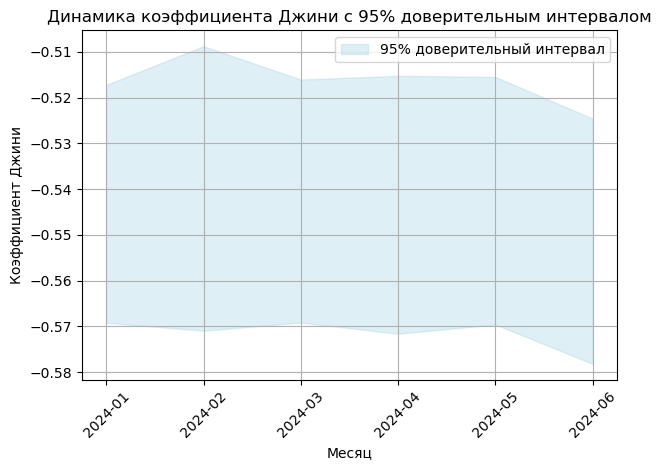

In [71]:
# Линии доверительного интервала
plt.fill_between(conf_df['scoring_month_str'],
                 conf_df['gini_lower'],
                 conf_df['gini_upper'],
                 color='lightblue',
                 alpha=0.4,
                 label='95% доверительный интервал')

plt.xticks(rotation=45)
plt.xlabel('Месяц')
plt.ylabel('Коэффициент Джини')
plt.title('Динамика коэффициента Джини с 95% доверительным интервалом')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Аплифт от использования внешнего скора: найти разницу между значениями Gini финального и внутреннего скора на каждый месячный срез

In [178]:
print(df_gini.columns)

Index(['scoring_month', 'loan_id_x', 'event_time_x', 'model_id_x',
       'gini_internal', 'default_flag_x', 'loan_id_y', 'event_time_y',
       'model_id_y', 'gini_final', 'default_flag_y', 'gini_diff'],
      dtype='object')


In [179]:
# Добавляем колонку месяца
df_scores['scoring_month'] = pd.to_datetime(df_scores['event_time']).dt.to_period('M')

In [180]:
# Вычисляем Gini внутреннего скоринга
gini_internal = df_scores[df_scores['model_id'] == 'internal_model_id'].groupby('scoring_month').apply(
    lambda x: gini_normalized(x['default_flag'], x['score']),
    include_groups=False
).reset_index()

In [181]:
# Расчет Gini для внешнего скоринга
gini_external = df_scores[df_scores['model_id'] == 'pd-auto-online'].groupby('scoring_month').apply(
    lambda x: gini_normalized(x['default_flag'], x['score']),
    include_groups=False
).reset_index().rename(columns={0: 'gini_external'})

In [182]:
# Приводим scoring_month к строке для корректного объединения
gini_internal['scoring_month'] = gini_internal['scoring_month'].astype(str)
gini_external['scoring_month'] = gini_external['scoring_month'].astype(str)

In [183]:
# Объединяем по месяцу
df_gini = pd.merge(gini_internal, gini_external, on='scoring_month')

In [185]:
print(df_gini.columns)

Index(['scoring_month', 'loan_id', 'event_time', 'model_id', 'score',
       'default_flag', 'gini_external'],
      dtype='object')


In [186]:
df_gini = df_gini.rename(columns={'score': 'gini_internal'})

In [189]:
print(df_scores[df_scores['model_id'] == 'pd-cc-online'].head())
print(df_scores['model_id'].unique())

           loan_id              event_time      model_id     score  \
0   CC2024043011d0 2024-04-30 07:16:48.741  pd-cc-online  0.134959   
3   CC202403029ee2 2024-03-02 23:00:46.748  pd-cc-online  0.150639   
8   CC2024041711f6 2024-04-17 16:21:03.891  pd-cc-online  0.259464   
9   CC2024010863b3 2024-01-08 16:17:31.049  pd-cc-online  0.216670   
12  CC20240601b698 2024-06-01 00:27:48.612  pd-cc-online  0.148389   

    default_flag scoring_month  
0          False       2024-04  
3          False       2024-03  
8          False       2024-04  
9          False       2024-01  
12         False       2024-06  
['pd-cc-online' 'pd-auto-online' 'pd-mortgage-online']


In [190]:
# Выбираем данные по внутреннему скорингу
df_internal = df_scores[df_scores['model_id'] == 'pd-cc-online']

In [191]:
# Используем одну группу месяца для теста
month = df_internal['scoring_month'].iloc[0]
test_group = df_internal[df_internal['scoring_month'] == month]

In [192]:
# Вычисляем Gini для тестовой группы
result = gini_normalized(test_group['default_flag'], test_group['score'])
print(f"Gini for {month}: {result}")

Gini for 2024-04: nan


C:\Users\andreyb\AppData\Local\Temp\ipykernel_8636\3327343732.py:7: RuntimeWarning: invalid value encountered in scalar divide
  gini_sum = all_data[:,0].cumsum().sum() / total_losses


In [193]:
def gini_normalized(y_true, y_scores):
    import numpy as np
    
    # пример простой реализации с проверкой
    all_data = np.asarray(np.c_[y_true, y_scores])
    all_data = all_data[np.argsort(all_data[:, 1])]
    total_losses = all_data[:, 0].sum()
    if total_losses == 0:
        return np.nan  # или 0, или другое значение по договоренности
    
    gini_sum = all_data[:, 0].cumsum().sum() / total_losses
    n = len(y_true)
    
    gini_index = 2 * gini_sum / n - (n + 1) / n
    return gini_index

In [194]:
def gini_normalized_safe(y_true, y_scores):
    if y_true.sum() == 0:
        return np.nan
    else:
        return gini_normalized(y_true, y_scores)

In [196]:
gini_internal = df_scores[df_scores['model_id'] == 'pd-cc-online'].groupby('scoring_month').apply(
    lambda x: gini_normalized_safe(x['default_flag'], x['score']),
    include_groups=False
).reset_index().rename(columns={0: 'gini_internal'})

In [198]:
gini_external = df_scores[df_scores['model_id'] == 'pd-auto-online'].groupby('scoring_month').apply(
    lambda x: gini_normalized_safe(x['default_flag'], x['score']),
    include_groups=False
).reset_index().rename(columns={0: 'gini_external'})

In [199]:
# Приводим scoring_month к строковому типу для объединения
gini_internal['scoring_month'] = gini_internal['scoring_month'].astype(str)
gini_external['scoring_month'] = gini_external['scoring_month'].astype(str)

In [200]:
# Объединяем обе таблицы по месяцу
df_gini = pd.merge(gini_internal, gini_external, on='scoring_month', how='inner')

In [203]:
# Рассчитываем аплифт - разницу Gini
df_gini['gini_lift'] = df_gini['gini_external'] - df_gini['gini_internal']

# Выводим результат
print(df_gini)

  scoring_month  gini_internal  gini_external  gini_lift
0       2024-01            NaN       0.026242        NaN
1       2024-02            NaN      -0.015906        NaN
2       2024-03            NaN       0.011739        NaN
3       2024-04            NaN       0.013442        NaN
4       2024-05            NaN       0.027777        NaN
5       2024-06            NaN       0.009144        NaN


In [204]:
# Рассчитаем среднее значение Gini внешнего скоринга, игнорируя NaN
mean_gini_external = df_gini['gini_external'].mean()

In [205]:
# Выведем среднее значение
print(f"Среднее значение Gini внешнего скоринга: {mean_gini_external:.4f}")

Среднее значение Gini внешнего скоринга: 0.0121


In [206]:
# Выставим цвет сигнала по значениям
if mean_gini_external < 0.35:
    signal = "Красный"
elif 0.35 <= mean_gini_external <= 0.50:
    signal = "Жёлтый"
else:
    signal = "Зелёный"

print(f"Сигнал качества финального скоринга: {signal}")

Сигнал качества финального скоринга: Красный
